In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import pickle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
data_file = 'data/ca-GrQc.txt'

In [3]:
data = pd.read_csv(data_file, sep = ' ', header = None)
left_nodes = data[0].values
right_nodes = data[1].values
combined_nodes = np.concatenate((left_nodes, right_nodes), axis = 0)
combined_nodes = np.unique(combined_nodes)

In [4]:
def get_unique(arr):
    unique = []
    for i in arr:
        if i not in unique:
            unique.append(i)
    return unique

In [5]:
def get_graph(combined_nodes, left_nodes, right_nodes):
    neighbors = []
    graph = {}

    for node in combined_nodes:
        if node in left_nodes:
            indices = np.where(left_nodes == node)
            for index in indices:
                neighbors.append(right_nodes[index])
        if node in right_nodes:
            indices = np.where(right_nodes == node)
            for index in indices:
                neighbors.append(left_nodes[index])

        unique_neighbors = get_unique(neighbors[0])

        unique_neighbors = np.array(unique_neighbors)
        graph[node] = unique_neighbors
        neighbors = []
    
    return graph


graph = get_graph(combined_nodes, left_nodes, right_nodes)

In [6]:
def get_adjacency_matrix(graph):
    adjacency_matrix = np.zeros([len(graph), len(graph)])

    for key, value in graph.items():
        for neighbor in value:
            adjacency_matrix[key][value] = 1
    
    return np.array(adjacency_matrix)
    
adjacency_matrix = get_adjacency_matrix(graph)

In [7]:
def get_degree_matrix(adjacency_matrix):
    degree_matrix = np.zeros([len(adjacency_matrix), len(adjacency_matrix)])
    
    for row_index in range(len(adjacency_matrix)):
        degree_matrix[row_index][row_index] = np.sum(adjacency_matrix[row_index])

    return degree_matrix

degree_matrix = get_degree_matrix(adjacency_matrix)

In [8]:
def get_laplacian_matrix(adjacency_matrix, degree_matrix):
    laplacian_matrix = np.subtract(degree_matrix, adjacency_matrix)
    return laplacian_matrix

laplacian_matrix = get_laplacian_matrix(adjacency_matrix, degree_matrix)

In [9]:
def get_eigen(laplacian_matrix):
    eig_values, eig_vectors = LA.eig(laplacian_matrix)
    return eig_values, eig_vectors

eig_values, eig_vectors = get_eigen(laplacian_matrix)

In [10]:
def least_significat_vectors(k, eig_values, eig_vectors):
    idx = eig_values.argsort()[:k]
    eig_vectors = eig_vectors[:, idx]
    eig_values = eig_values[idx]
    
    return eig_vectors, eig_values

least_vectors, least_values = least_significat_vectors(5, eig_values, eig_vectors)

least_values = least_values.real
least_vectors = least_vectors.real

Text(0.5, 1.0, 'Eigenvelues')

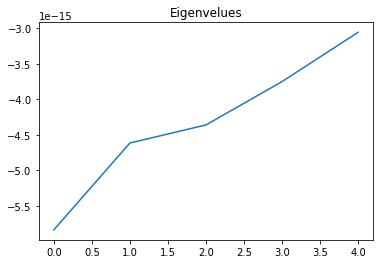

In [11]:
# Visualize least significant eigenvalues
plt.plot(least_values)
plt.title('Eigenvelues')

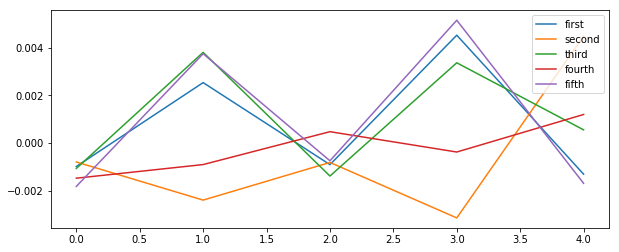

In [12]:
# Visualize least significant eigenvectors

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(least_vectors[:][0], label='first')
plt.plot(least_vectors[:][1], label='second')
plt.plot(least_vectors[:][2], label='third')
plt.plot(least_vectors[:][3], label='fourth')
plt.plot(least_vectors[:][4], label='fifth')
plt.legend(loc='upper right')
plt.show()

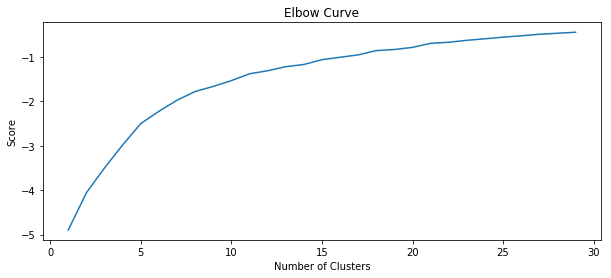

In [13]:
def elbow(least_vectors, num_clusters):
    number_clusters = range(1, num_clusters)

    kmeans = [KMeans(n_clusters = i) for i in number_clusters]

    score = [kmeans[i].fit(least_vectors).score(least_vectors) for i in range(len(kmeans))]

    score

    plt.plot(number_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

elbow(least_vectors, 30)

In [14]:
num_clusters = 10

kmeans = KMeans(
    n_clusters = num_clusters, 
    random_state = 0
)

kmeans.fit(least_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

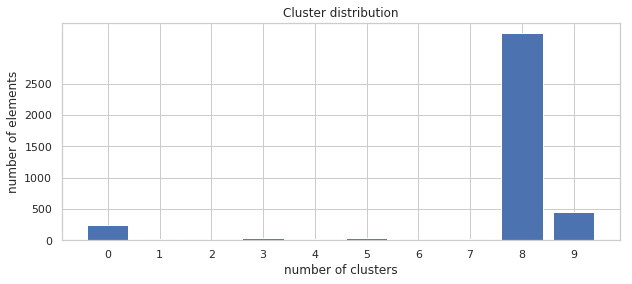

In [31]:
# Visualize cluster distribution
distribution = []
clusters = np.arange(0, num_clusters)

for cluster in range(num_clusters):

    elements = np.where(kmeans.labels_ == cluster)[0]
    elements = len(elements)
    distribution.append(elements)
    
plt.bar(clusters, distribution)
plt.xticks(clusters)
plt.yticks(np.arange(0, 3000, 500))
plt.xlabel('number of clusters')
plt.ylabel('number of elements')
plt.title('Cluster distribution')
plt.show()

In [ ]:
df = pd.DataFrame({'node' : combined_nodes, 'cluster' : kmeans.labels_})
df = df[['node', 'cluster']]
df.to_csv('clusters.csv', index = False)